## Intro to deep learning for medical imaging by [MD.ai](https://www.md.ai)

## Lesson 3. RSNA Pneumonia Detection Challenge (MD.ai API)

The [Radiological Society of North America](http://www.rsna.org/) Pneumonia Detection Challenge: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge

This notebook covers the basics of parsing the competition dataset, training using a detector basd on the [Mask-RCNN algorithm](https://arxiv.org/abs/1703.06870) for object detection and instance segmentation.  

This notebook is developed by [MD.ai](https://www.md.ai), the platform for medical AI. 
This notebook requires Google's [TensorFlow](https://www.tensorflow.org/) machine learning framework.

- MD.ai annotator project URL for this dataset: https://public.md.ai/annotator/project/LxR6zdR2/workspace
- MD.ai python client libray URL: https://github.com/mdai/mdai-client-py
- MD.ai documentation URL: https://docs.md.ai/

**Intro to deep learning for medical imaging lessons**

- Lesson 1. Classification of chest vs. adominal X-rays using TensorFlow/Keras [Github](https://github.com/mdai/ml-lessons/blob/master/lesson1-xray-images-classification.ipynb) [Annotator](https://public.md.ai/annotator/project/PVq9raBJ)

- Lesson 2. Lung X-Rays Semantic Segmentation using UNets. [Github](https://github.com/mdai/ml-lessons/blob/master/lesson2-lung-xrays-segmentation.ipynb)
[Annotator](https://public.md.ai/annotator/project/aGq4k6NW/workspace) 

- Lesson 3. RSNA Pneumonia detection using Kaggle data format [Github](https://github.com/mdai/ml-lessons/blob/master/lesson3-rsna-pneumonia-detection-kaggle.ipynb) [Annotator](https://public.md.ai/annotator/project/LxR6zdR2/workspace) 
  
- Lesson 3. RSNA Pneumonia detection using MD.ai python client library [Github](https://github.com/mdai/ml-lessons/blob/master/lesson3-rsna-pneumonia-detection-mdai-client-lib.ipynb) [Annotator](https://public.md.ai/annotator/project/LxR6zdR2/workspace)

*Copyright 2018 MD.ai, Inc.   
Licensed under the Apache License, Version 2.0*

In [0]:
# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug 

In [0]:
import os
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa

%matplotlib inline 

### Import the `mdai` library

On Colab, run the block below to install the `mdai` client library into your python environment.

In [26]:
!pip install --upgrade --quiet mdai
import mdai
mdai.__version__

'0.0.5'

In [0]:
# Root directory of the project
ROOT_DIR = os.path.abspath('./lesson3-data')

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)
os.chdir(ROOT_DIR)

### Install Matterport's Mask-RCNN model from github.
See the [Matterport's implementation of Mask-RCNN](https://github.com/matterport/Mask_RCNN).

In [28]:
!git clone https://github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
!pip install -q -r requirements.txt
!python setup.py -q install

Cloning into 'Mask_RCNN'...
remote: Counting objects: 775, done.
remote: Total 775 (delta 0), reused 0 (delta 0), pack-reused 774
Receiving objects: 100% (775/775), 107.33 MiB | 20.46 MiB/s, done.
Resolving deltas: 100% (446/446), done.
zip_safe flag not set; analyzing archive contents...


In [0]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

### Create an `mdai` client

The mdai client requires an access token, which authenticates you as the user. To create a new token or select an existing token, navigate to the "Personal Access Tokens" tab on your user settings page at the specified MD.ai domain (e.g., public.md.ai).

**Important: keep your access tokens safe. Do not ever share your tokens.**

In [30]:
mdai_client = mdai.Client(domain='public.md.ai', access_token="")

Successfully authenticated to public.md.ai.


### Clone the Annotator Project

The annotator project URL for this dataset is https://public.md.ai/annotator/project/LxR6zdR2/workspace. 

To add annotations to the cloned project, you need to clone the project first. 

First, navigate to the original project URL (above), click on "Clone Project" button. 

![GitHub Logo](https://raw.githubusercontent.com/mdai/ml-lessons/master/images/kaggle-project-clone-small.gif)


### Define project

Define a project you have access to by passing in the project id. The project id can be found in the URL in the following format: `https://public.md.ai/annotator/project/{project_id}`.

For example, `project_id` would be `XXXX` for `https://public.md.ai/annotator/project/XXXX`.

Specify optional `path` as the data directory (if left blank, will default to current working directory).

In [0]:
p = mdai_client.project('LxR6zdR2', path='./lesson3-data')

## Prepare data

In [0]:
p.show_label_groups()

Label Group, Id: G_R28gN5, Name: Default group
	Labels:
	Id: L_ylR0L8, Name: No Lung Opacity
	Id: L_DlqEAl, Name: Lung Opacity



### Set label ids

Selected label ids must be explicitly set by `Project#set_label_ids` method in order to prepare datasets.

In [0]:
# this maps label ids to class ids
labels_dict = {'L_ylR0L8':0, # background 
               'L_DlqEAl':1, # lung opacity 
              }

print(labels_dict)
p.set_labels_dict(labels_dict)

{'L_ylR0L8': 0, 'L_DlqEAl': 1}
None
bbox


In [0]:
p.show_datasets()

Datasets:
Id: D_ao3XWQ, Name: stage 1 train



In [0]:
dataset = p.get_dataset_by_id('D_ao3XWQ')
dataset.prepare()

In [0]:
dataset.show_classes()

Label id: L_ylR0L8, Class id: 0, Class text: No Lung Opacity
Label id: L_DlqEAl, Class id: 1, Class text: Lung Opacity


In [0]:
anns = dataset.get_annotations()

### Split the data into training and validation datasets

In [0]:
train_dataset, valid_dataset = mdai.common_utils.train_test_split(dataset)

Num of instances for training set: 23115, validation set: 2569


In [0]:
anns = dataset.get_annotations(labels_dict.keys(), verbose=True)

Dataset contains 28989 annotations, filtered by label ids dict_keys(['L_ylR0L8', 'L_DlqEAl']).


### Mask-RCNN Config

see [https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/config.py](https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/config.py)

In [0]:
# These parameters have been changed to reduce run-time per epoch at the expense 
# of training performance

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    NAME = 'pneumonia'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 16 # on aws, use 16
    BACKBONE = 'resnet50'
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    IMAGE_MIN_DIM = 64
    IMAGE_MAX_DIM = 64
    RPN_ANCHOR_SCALES = (32, 64)
    TRAIN_ROIS_PER_IMAGE = 16
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_NMS_THRESHOLD = 0.1
    POST_NMS_ROIS_TRAINING = 200
    RPN_TRAIN_ANCHORS_PER_IMAGE = 16
    STEPS_PER_EPOCH = 100 
    TOP_DOWN_PYRAMID_SIZE = 32
     
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     16
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 16
IMAGE_MAX_DIM                  64
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  64
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [64 64  3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES      

### Mask-RCNN Dataset

see [https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/utils.py](https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/utils.py)

In [0]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, source_name, dataset, orig_height, orig_width):
        super().__init__(self)
        
        # add classes 
        for k, v in dataset.classes_dict.items():
            if v['class_id'] is not 0: 
                self.add_class(source_name, v['class_id'], v['class_text'])

        # add images 
        img_ids = dataset.get_image_ids()
        imgs_anns_dict = dataset.imgs_anns_dict
        
        #########################################################
        # WARNING: Using only the first 1000 images to reduce 
        #          run-time for demonstration only 
        # To run all images, do: for i, fp in enumerate(img_ids):
        #########################################################
        for i, fp in enumerate(img_ids[:1000]):
            annotations = imgs_anns_dict[fp]
            self.add_image(source_name, image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(
            fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            assert(dataset.label_id_to_class_id(a['labelId']) == 0)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['data'] is not None:
                    x = int(a['data']['x'])
                    y = int(a['data']['y'])
                    w = int(a['data']['width'])
                    h = int(a['data']['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = dataset.label_id_to_class_id(a['labelId'])
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [0]:
# Training dataset
source_name = 'pneumonia'
dataset_train = DetectorDataset(source_name, train_dataset, 1024, 1024)
dataset_train.prepare()

# Validation dataset
dataset_val = DetectorDataset(source_name, valid_dataset, 1024, 1024)
dataset_val.prepare()

### Display a few images

(-0.5, 1023.5, 1023.5, -0.5)

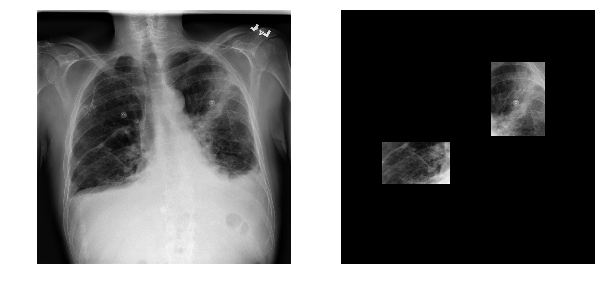

In [0]:
# Load and display random samples
image_id = random.choice(dataset_train.image_ids)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

### Training

In [0]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)

In [0]:
augmentation = iaa.SomeOf((0, 1), [
    iaa.Fliplr(0.5),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    ),
    iaa.Multiply((0.9, 1.1))
])

## To get good results, you need to train for many epochs. 

In [0]:
# increase the number of epochs for (potentially) better trained model
NUM_EPOCHS = 1

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=NUM_EPOCHS, 
            #augmentation=augmentation, # uncomment to enable augmentation
            layers='all')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/lesson3-data/logs/pneumonia20180827T1517/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a

### Evaluate model on few random images

In [0]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else: 
      
      checkpoint = os.path.join(dir_name, checkpoints[-1])
      fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model /content/lesson3-data/logs/pneumonia20180827T1517/mask_rcnn_pneumonia_0001.h5


In [0]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
inference_config.display()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  64
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  64
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [64 64  3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES        

In [0]:
def show_randoms(dataset):
    fig = plt.figure(figsize=(10,20))

    num_imgs = 3 
    for i in range(num_imgs):

        image_id = random.choice(dataset.image_ids)
        original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, inference_config, 
                                   image_id, use_mini_mask=False)
     
        plt.subplot(num_imgs, 2, 2*i + 1)
        visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                    dataset.class_names,
                                    colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
        plt.title('Ground Truth')
        
        plt.subplot(num_imgs, 2, 2*i + 2)
        
        # turn off verbose if you don't want debug messages 
        results = model.detect([original_image],verbose=1)
        r = results[0]
        visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                    dataset.class_names, r['scores'], 
                                    colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])
        plt.title('Prediction')

In [0]:
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors


*** No instances to display *** 

Processing 1 images
image                    shape: (64, 64, 3)           min:    6.00000  max:  242.00000  uint8
molded_images            shape: (1, 64, 64, 3)        min: -117.70000  max:  138.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:   64.00000  int64
anchors                  shape: (1, 960, 4)           min:   -0.71833  max:    1.59135  float32
Processing 1 images
image                    shape: (64, 64, 3)           min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 64, 64, 3)        min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:   64.00000  int64
anchors                  shape: (1, 960, 4)           min:   -0.71833  max:    1.59135  float32

*** No instances to display *** 

Processing 1 images
image                    shape: (64, 64, 3)           min:    0.00000  max:  247.00000  uint8
molded_images   

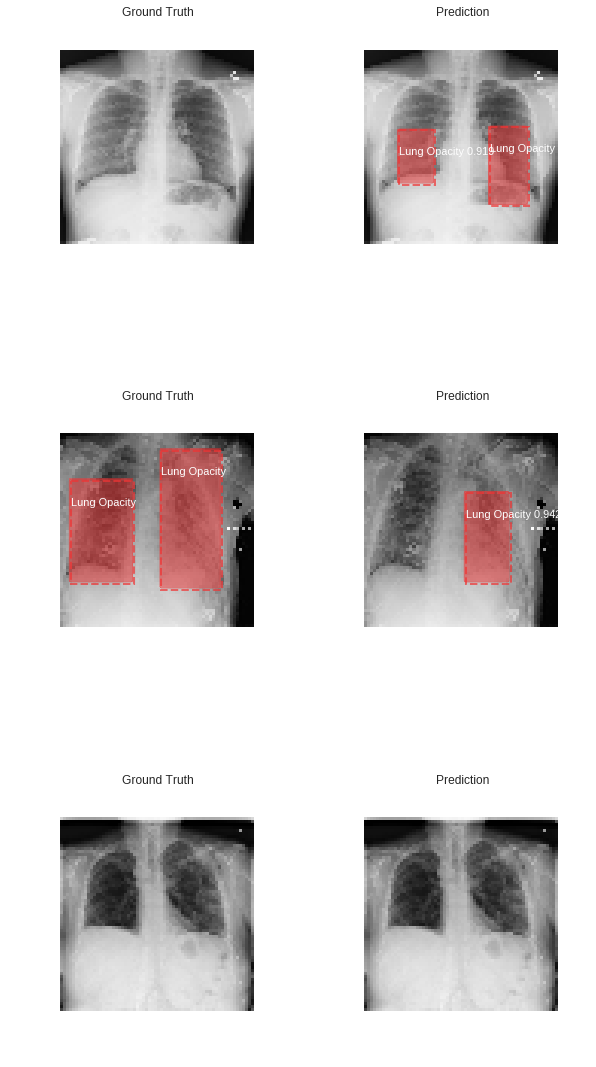

In [0]:
show_randoms(dataset_val)